In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
import numpy as np

import torch
from torch import nn
from utils import parse_cfg, iou_vectorized
from darknet import Darknet

In [2]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch


In [3]:
x = torch.randn((2, 3, 416, 416))
darknet.forward(x, 'cpu').shape
# todo what is after .forward

torch.FloatTensor


/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 10647, 85])

In [4]:
weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)

In [22]:
type(torch.device('cpu'))

torch.device

In [20]:
# todo nms
x = torch.randn((2, 3, 416, 416))
device = torch.device('cpu:0')
predictions = darknet.forward(x, device)
predictions[:, :, 4] *= 1000 # to be removed. just for testing
objectness_thres = 0.2
nms_thres = 0.4
classes = 80 # darknet.layers_list[-1][0].classes

torch.FloatTensor


/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [6]:
bboxes1 = torch.Tensor([(6, 5, 4, 2), (3, 6, 4, 2), (8, 4, 2, 8), (11, 7, 2, 2), (8, 0, 4, 2)]).float()
bboxes2 = bboxes1[0].unsqueeze(0)

iou_vectorized(bboxes1, bboxes2)

tensor([[1.0000],
        [0.0667],
        [0.0909],
        [0.0000],
        [0.0000]])

In [148]:
# Non-max Suppression:
# 1. Filter out predictions with low objectness score
# 2. 
# objectiveness filtering:
# replace all boxes with predicted probability lower than objectness_thres 
# with zeros: calculate 0/1 mask and apply it to the prediction tensor
# Note: '>' returns Byte but '*' needs Float unsqueezed back to 3D
# objectness_mask = (predictions[:, :, 4] > objectness_thres).float().unsqueeze(2)
# predictions = predictions * objectness_mask

# # 


# image_pred = predictions[0]
# image_pred.shape

In [201]:
print('changing predictions in the nms loop make sure that it is not used later')

detections = [None] * len(predictions)

for i, prediction in enumerate(predictions):
    print(prediction.shape)
    objectness_mask = (prediction[:, 4] > objectness_thres)#.float().unsqueeze(1)
    prediction = prediction[objectness_mask]
    
    # if no object on an image found, continue with the next image
    if prediction.size(0) == 0:
        continue
        
    print(prediction.shape)
    pred_score, pred_classes = torch.max(prediction[:, 5:5+classes], dim=1, keepdim=True)
    print(pred_classes.shape, pred_score.shape)
    # detections: (cx, cy, w, h, obj_score, top_class_score, top_class_idx)
    prediction = torch.cat((prediction[:, :5], pred_score.float(), pred_classes.float()), dim=1)
    print(prediction.shape)
    unique_classes = pred_classes.unique().float()
    print(unique_classes.shape)
    
    for cls in unique_classes:
        prediction_4_cls = prediction[prediction[:, 6] == cls]
        sort_pred_idxs = torch.sort(prediction_4_cls[:, 4], descending=True)[1]
        prediction_4_cls = prediction_4_cls[sort_pred_idxs]
        
        detections_after_nms = [prediction_4_cls[0]]
        
        while True:
            print(prediction_4_cls[0, :5].shape, prediction_4_cls[1:, :5].shape)
            iou_vectorized(prediction_4_cls[0, :5], prediction_4_cls[1:, :5])
            
            prediction_4_cls
            
        # append to detections

changing predictions in the nms loop make sure that it is not used later
torch.Size([10647, 85])
torch.Size([1502, 85])
torch.Size([1502, 1]) torch.Size([1502, 1])
torch.Size([1502, 7])
torch.Size([60])
torch.Size([5]) torch.Size([2, 5])


NameError: name 'iou_vectorized' is not defined

In [142]:
predictions = torch.rand((2, 4, 5))

for i, a in enumerate(b):
    print(a)
    score, classes = torch.max(a, dim=1, keepdim=True)
    
    print(score, classes)
    print()

tensor([[0.1062, 0.4194, 0.3074, 0.5666, 0.0054],
        [0.3898, 0.7219, 0.9403, 0.7240, 0.3061],
        [0.3742, 0.9673, 0.0168, 0.8975, 0.5089],
        [0.9671, 0.8732, 0.7468, 0.1421, 0.0777]])
tensor([[0.5666],
        [0.9403],
        [0.9673],
        [0.9671]]) tensor([[3],
        [2],
        [1],
        [0]])

tensor([[0.7645, 0.6655, 0.2982, 0.6881, 0.0386],
        [0.4113, 0.3835, 0.3328, 0.3215, 0.1262],
        [0.4036, 0.6855, 0.4807, 0.9100, 0.4675],
        [0.7750, 0.6575, 0.1429, 0.0369, 0.0872]])
tensor([[0.7645],
        [0.4113],
        [0.9100],
        [0.7750]]) tensor([[0],
        [0],
        [3],
        [0]])



(452, 602, 3)


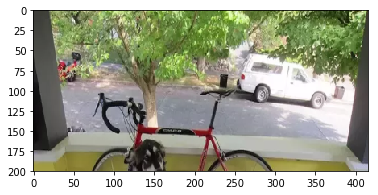

torch.Size([1, 3, 200, 416])
torch.FloatTensor


RuntimeError: The size of tensor a (273) must match the size of tensor b (147) at non-singleton dimension 1

In [12]:
from matplotlib import pyplot as plt
import cv2

plt.figure()
img = cv2.imread('dog-cycle-car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img = cv2.resize(img, (416, 416)) / 255
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
print(img.shape)
pred = darknet.forward(img, 'cpu')
pred

In [4]:
weight_file = 'weights/yolov3.weights'

In [29]:
r_file = open(weight_file, 'rb')
# header consists on version numbers (major, minor, subversion)
# and number of images seen by model during training
header = np.fromfile(r_file, dtype=np.int32, count=5)
# the rest are weights in a form of a vector (not matrix)
weights = np.fromfile(r_file, dtype=np.float32)

idx = 0

for i, layer in enumerate(self_layers_list):
    # i+1 because 0th is net_info
    name = self_layers_info[i+1]['name']
    
    if name == 'convolutional':
        
        # some conv layers doesn't have bn layers
        try:
            self_layers_info[i+1]['batch_normalize']
            conv, bn = self_layers_list[i][:2]
            
            # 1. load and convert the selected weights to a Tensor
            # 2. reshape loaded weights as the current ones
            # 3. replace the current weights with the loaded ones
            # 4. increment the current counter of read weights
            
            # num of bn weights
            bn_weigth_num = bn.bias.numel()
            
            # bn biases
            bn_b = torch.Tensor(weights[idx:idx+bn_weigth_num])
            bn_b = bn_b.view_as(bn.bias.data)
            bn.bias.data.copy_(bn_b)
            idx += bn_weigth_num
            
            # bn weights
            bn_w = torch.Tensor(weights[idx:idx+bn_weigth_num])
            bn_w = bn_w.view_as(bn.weight.data)
            bn.weight.data.copy_(bn_w)
            idx += bn_weigth_num
            
            # bn running mean
            bn_running_mean = torch.Tensor(weights[idx:idx+bn_weigth_num])
            bn_running_mean = bn_running_mean.view_as(bn.running_mean.data)
            bn.running_mean.data.copy_(bn_running_mean)
            idx += bn_weigth_num
            
            # bn running var
            bn_running_var = torch.Tensor(weights[idx:idx+bn_weigth_num])
            bn_running_var = bn_running_var.view_as(bn.running_var.data)
            bn.running_var.data.copy_(bn_running_var)
            idx += bn_weigth_num
            
            # conv weights (no need to load biases if bn is used)
            conv_w_num = conv.weight.numel()
            conv_w = torch.Tensor(weights[idx:idx+conv_w_num])
            conv_w = conv_w.view_as(conv.weight.data)
            conv.weight.data.copy_(conv_w)
            idx += conv_w_num
            
        except KeyError:
            conv = self_layers_list[i][0]
            
            # conv biases
            conv_b_num = conv.bias.numel()
            conv_b = torch.Tensor(weights[idx:idx+conv_b_num])
            conv_b = conv_b.view_as(conv.bias.data)
            idx += conv_b_num
            
            # conv weights
            conv_w_num = conv.weight.numel()
            conv_w = torch.Tensor(weights[idx:idx+conv_w_num])
            conv_w = conv_w.view_as(conv.weight.data)
            conv.weight.data.copy_(conv_w)
            idx += conv_w_num
            
#             print('no bn detected at {}'.format(i))

no bn detected at 81
no bn detected at 93
no bn detected at 105


In [7]:
sum(p.numel() for p in darknet.parameters() if p.requires_grad)

AttributeError: 'Darknet' object has no attribute 'numel'

In [6]:
61949149 - 62001757

-52608

In [13]:
a = np.random.randn(2, 20)
torch.Tensor(a) == torch.from_numpy(a)

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'other'

In [17]:
torch.from_numpy(a).float()

tensor([[-0.4300,  1.0350, -1.4485,  0.5479,  0.5696,  0.0746, -0.2987,  1.0527,
          0.6135,  0.8221,  0.3758,  0.0354,  0.2996, -1.6952,  0.8315, -0.2314,
         -1.5974, -0.8013, -0.5810, -0.3443],
        [ 1.3962, -0.2143,  0.5346, -0.4582,  1.5713, -0.3214, -0.2613, -1.9544,
         -0.2469, -0.1107,  0.5556,  0.2298,  0.2509,  0.0696,  1.8551, -1.1813,
          1.9910, -1.0133,  0.1630,  0.2853]])

In [15]:
torch.Tensor(a)

tensor([[-0.4300,  1.0350, -1.4485,  0.5479,  0.5696,  0.0746, -0.2987,  1.0527,
          0.6135,  0.8221,  0.3758,  0.0354,  0.2996, -1.6952,  0.8315, -0.2314,
         -1.5974, -0.8013, -0.5810, -0.3443],
        [ 1.3962, -0.2143,  0.5346, -0.4582,  1.5713, -0.3214, -0.2613, -1.9544,
         -0.2469, -0.1107,  0.5556,  0.2298,  0.2509,  0.0696,  1.8551, -1.1813,
          1.9910, -1.0133,  0.1630,  0.2853]])

In [22]:
bn.runn.data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
nn.BatchNorm2d()